In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# Données qualitatives

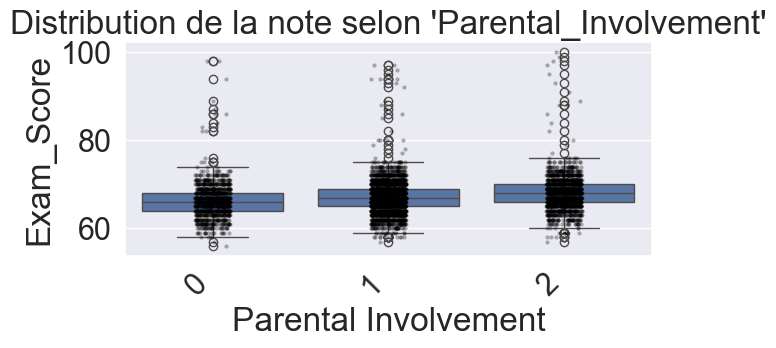

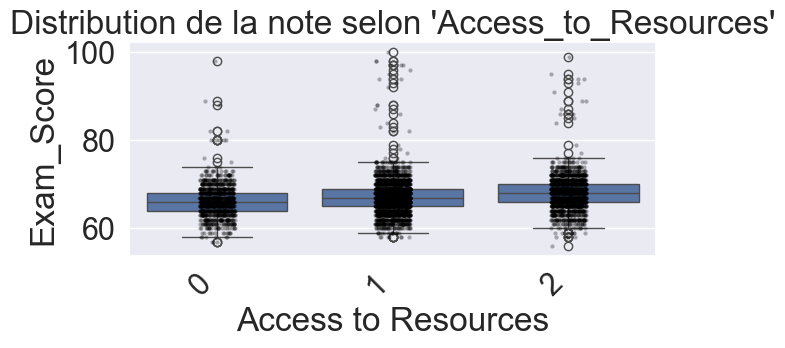

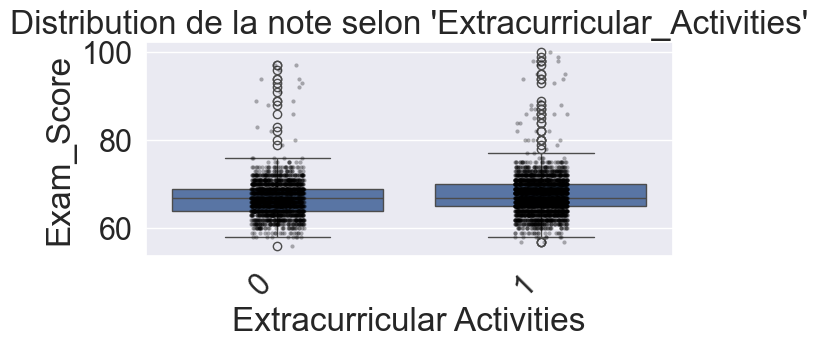

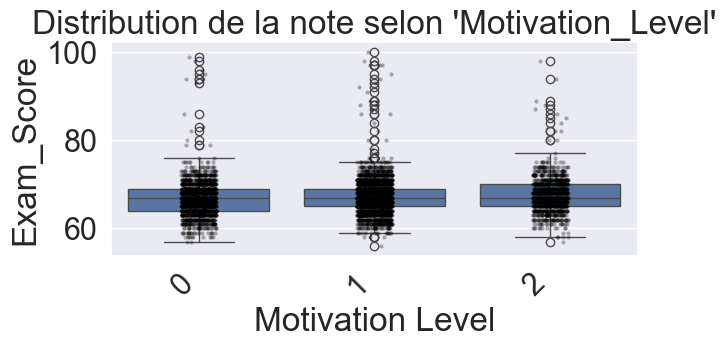

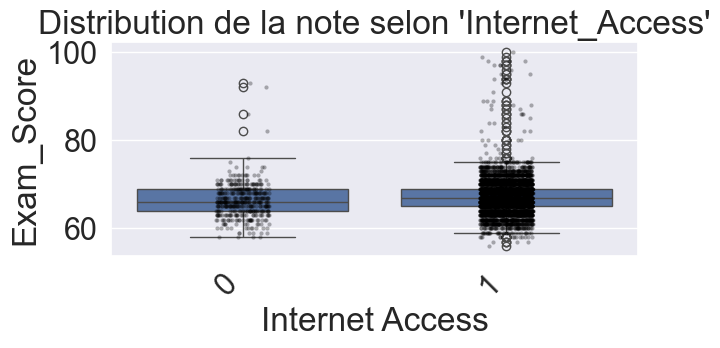

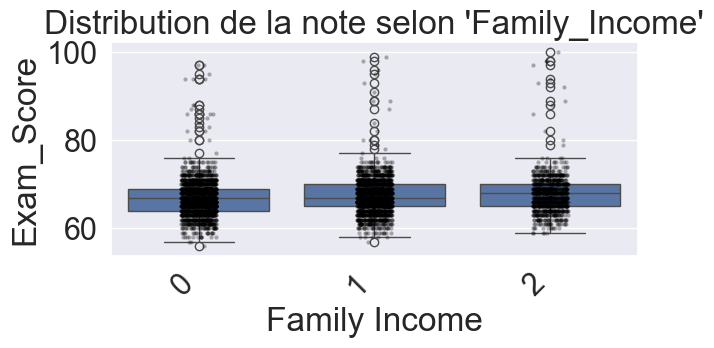

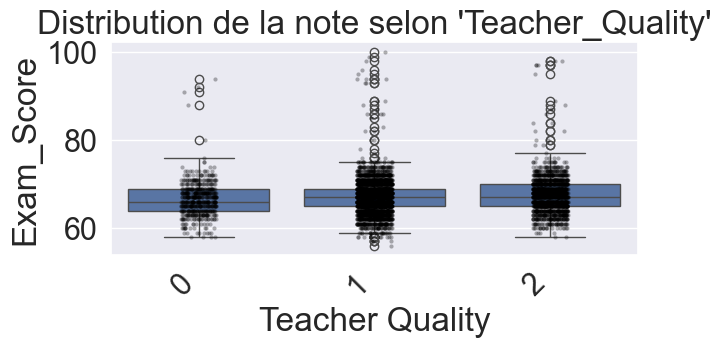

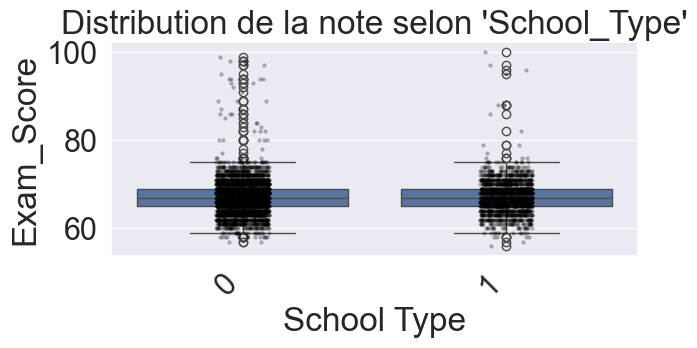

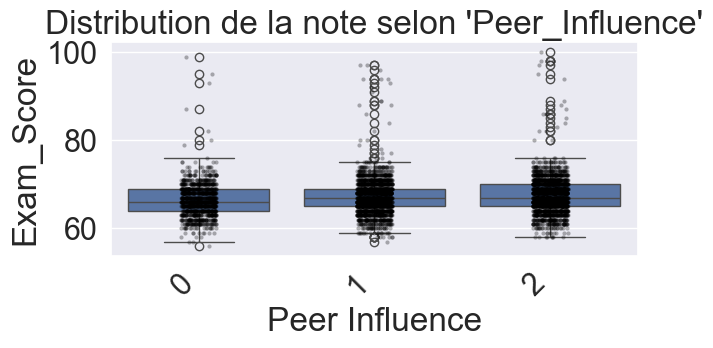

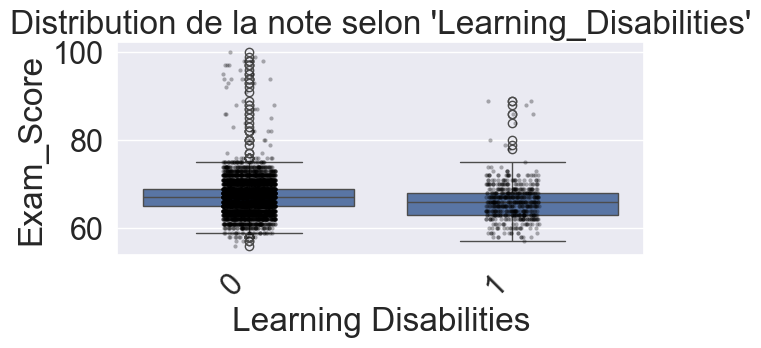

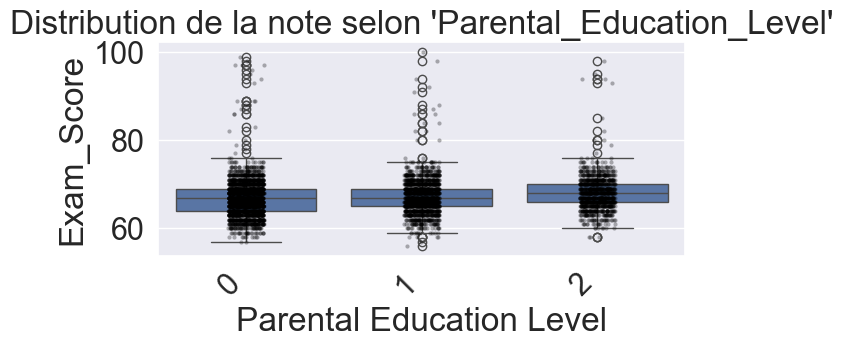

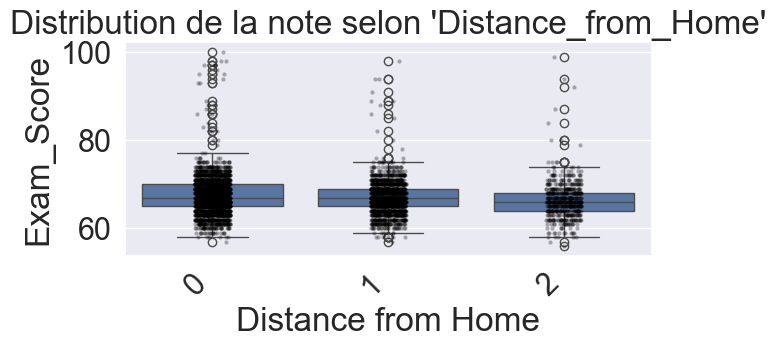

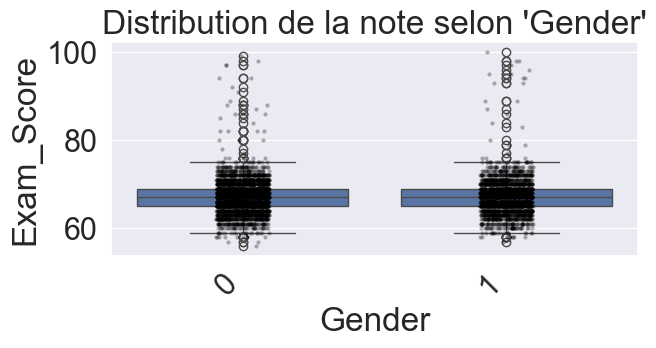

In [140]:
data_quali = pd.read_parquet("../data/clean_df_with_categoricals/")
qualitative_cols = [
    "Parental_Involvement", "Access_to_Resources", "Extracurricular_Activities",
    "Motivation_Level", "Internet_Access", "Family_Income", "Teacher_Quality",
    "School_Type", "Peer_Influence", "Learning_Disabilities",
    "Parental_Education_Level", "Distance_from_Home", "Gender"
]

# --- 2. Tracer un box-plot par variable --------------------------------------
for col in qualitative_cols:
    plt.figure(figsize=(7, 4))
    order = sorted(data_quali[col].dropna().unique())  # assure un ordre stable
    sns.boxplot(data=data_quali, x=col, y="Exam_Score", order=order)
    sns.stripplot(data=data_quali, x=col, y="Exam_Score", order=order,
                  size=3, color="black", alpha=0.3)        # points individuels
    plt.title(f"Distribution de la note selon '{col}'")
    plt.xlabel(col.replace("_", " "))
    plt.ylabel("Exam_Score")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

On peut constater que les données qualitatives n'ont pas un grand impact sur la note de l'examen, en effet :
- peu importe les valeurs les boites sont situés au même endroit
- les médianes changent peu
- les outliers peuvent être plus importants.



# Utilisation des données sans les variables qualitatives

In [141]:
data = pd.read_parquet("../data/clean_df/")

## Présentation des variables

In [142]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5915 entries, 0 to 5914
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Hours_Studied      5915 non-null   int32
 1   Attendance         5915 non-null   int32
 2   Sleep_Hours        5915 non-null   int32
 3   Previous_Scores    5915 non-null   int32
 4   Tutoring_Sessions  5915 non-null   int32
 5   Physical_Activity  5915 non-null   int32
 6   Exam_Score         5915 non-null   int32
dtypes: int32(7)
memory usage: 161.9 KB


## Moyenne, total, quartile, min max

In [143]:
print(data.shape)
data.describe()

(5915, 7)


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,5915.000000,5915.000000,5915.000000,5915.000000,5915.000000,5915.000000,5915.000000
mean,19.991040,79.985461,7.040406,75.080473,1.289265,2.962975,67.144379
std,5.822776,11.534313,1.468722,14.362626,0.982435,1.029074,3.844076
min,4.000000,60.000000,4.000000,50.000000,0.000000,0.000000,56.000000
25%,16.000000,70.000000,6.000000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.000000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.000000,88.000000,2.000000,4.000000,69.000000
max,36.000000,100.000000,10.000000,100.000000,3.000000,6.000000,100.000000


array([[<Axes: title={'center': 'Hours_Studied'}>,
        <Axes: title={'center': 'Attendance'}>,
        <Axes: title={'center': 'Sleep_Hours'}>],
       [<Axes: title={'center': 'Previous_Scores'}>,
        <Axes: title={'center': 'Tutoring_Sessions'}>,
        <Axes: title={'center': 'Physical_Activity'}>],
       [<Axes: title={'center': 'Exam_Score'}>, <Axes: >, <Axes: >]],
      dtype=object)

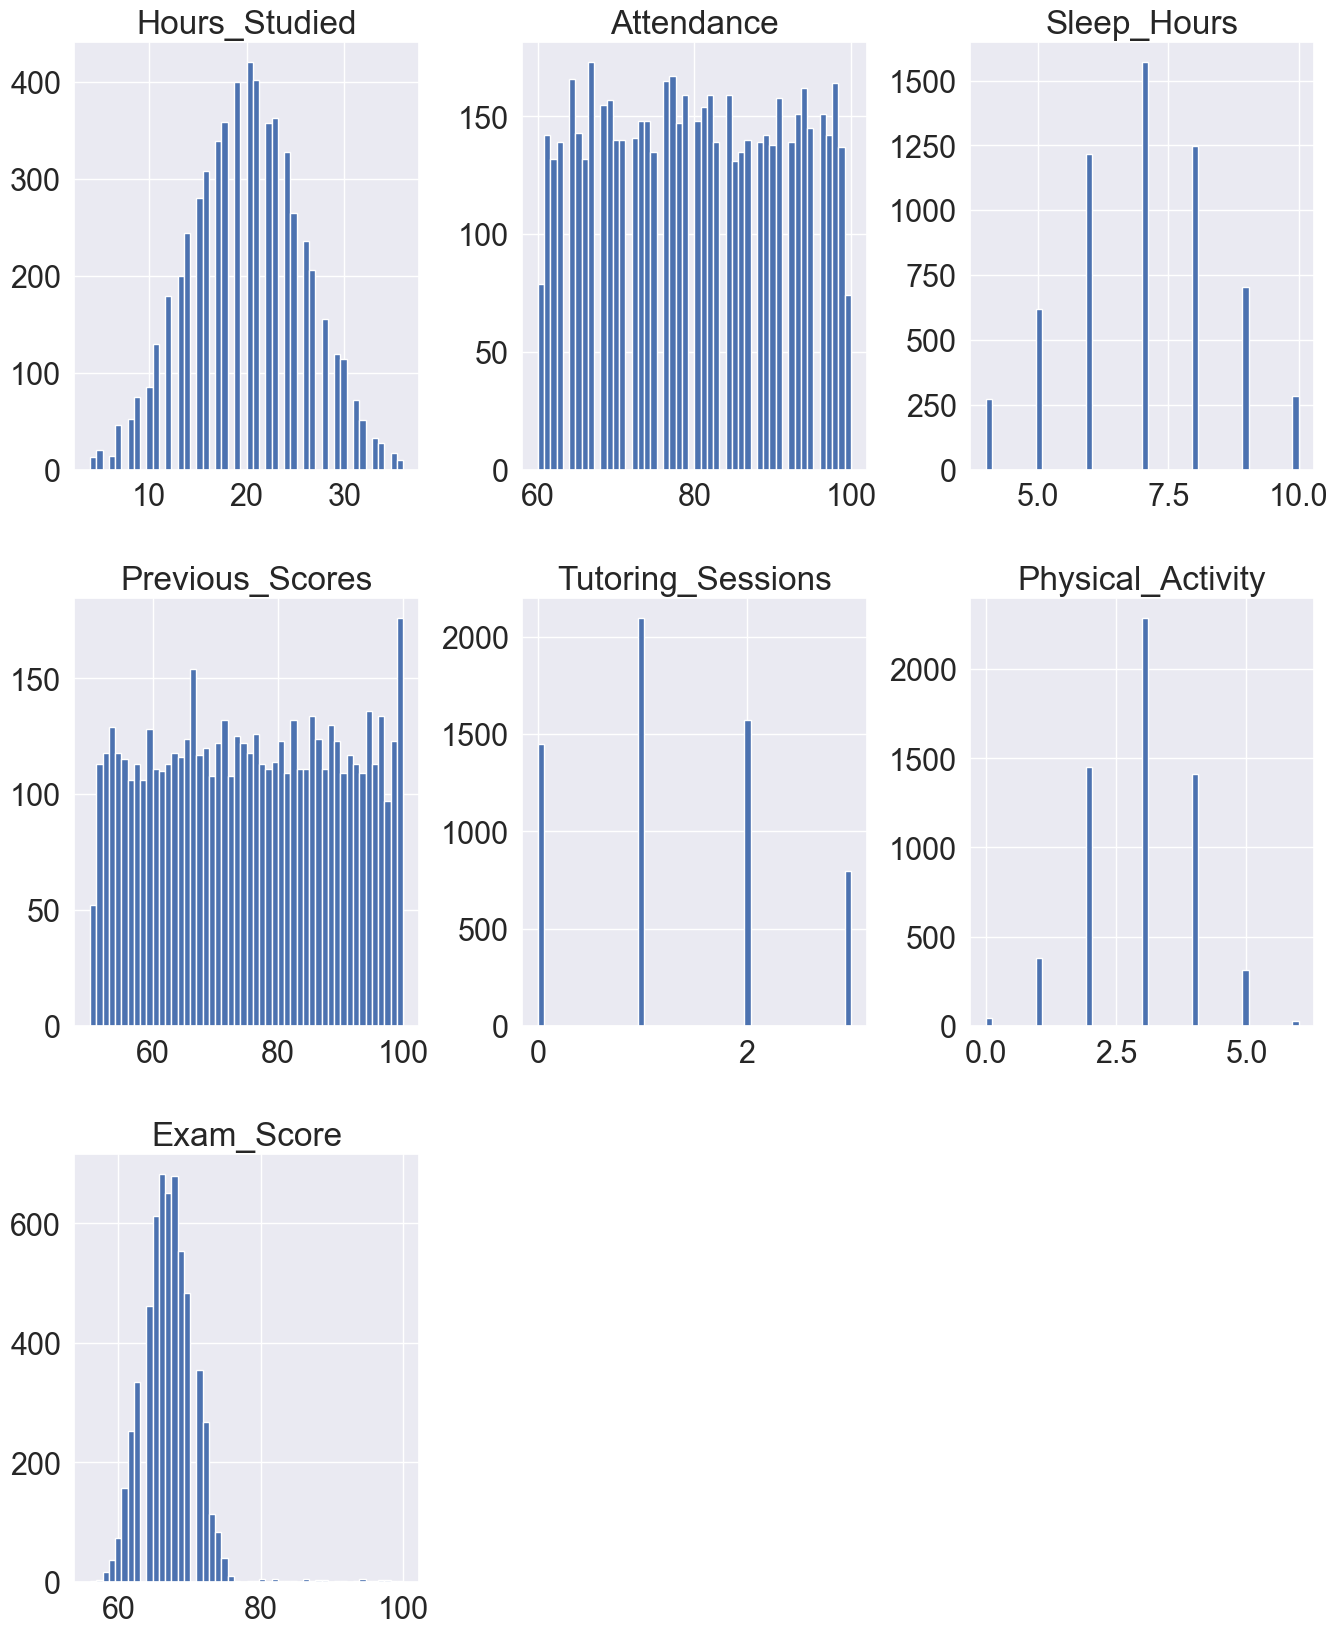

In [144]:
data.hist(figsize=(16,20), bins=50)

## Matrice de corrélation des variables

<Axes: >

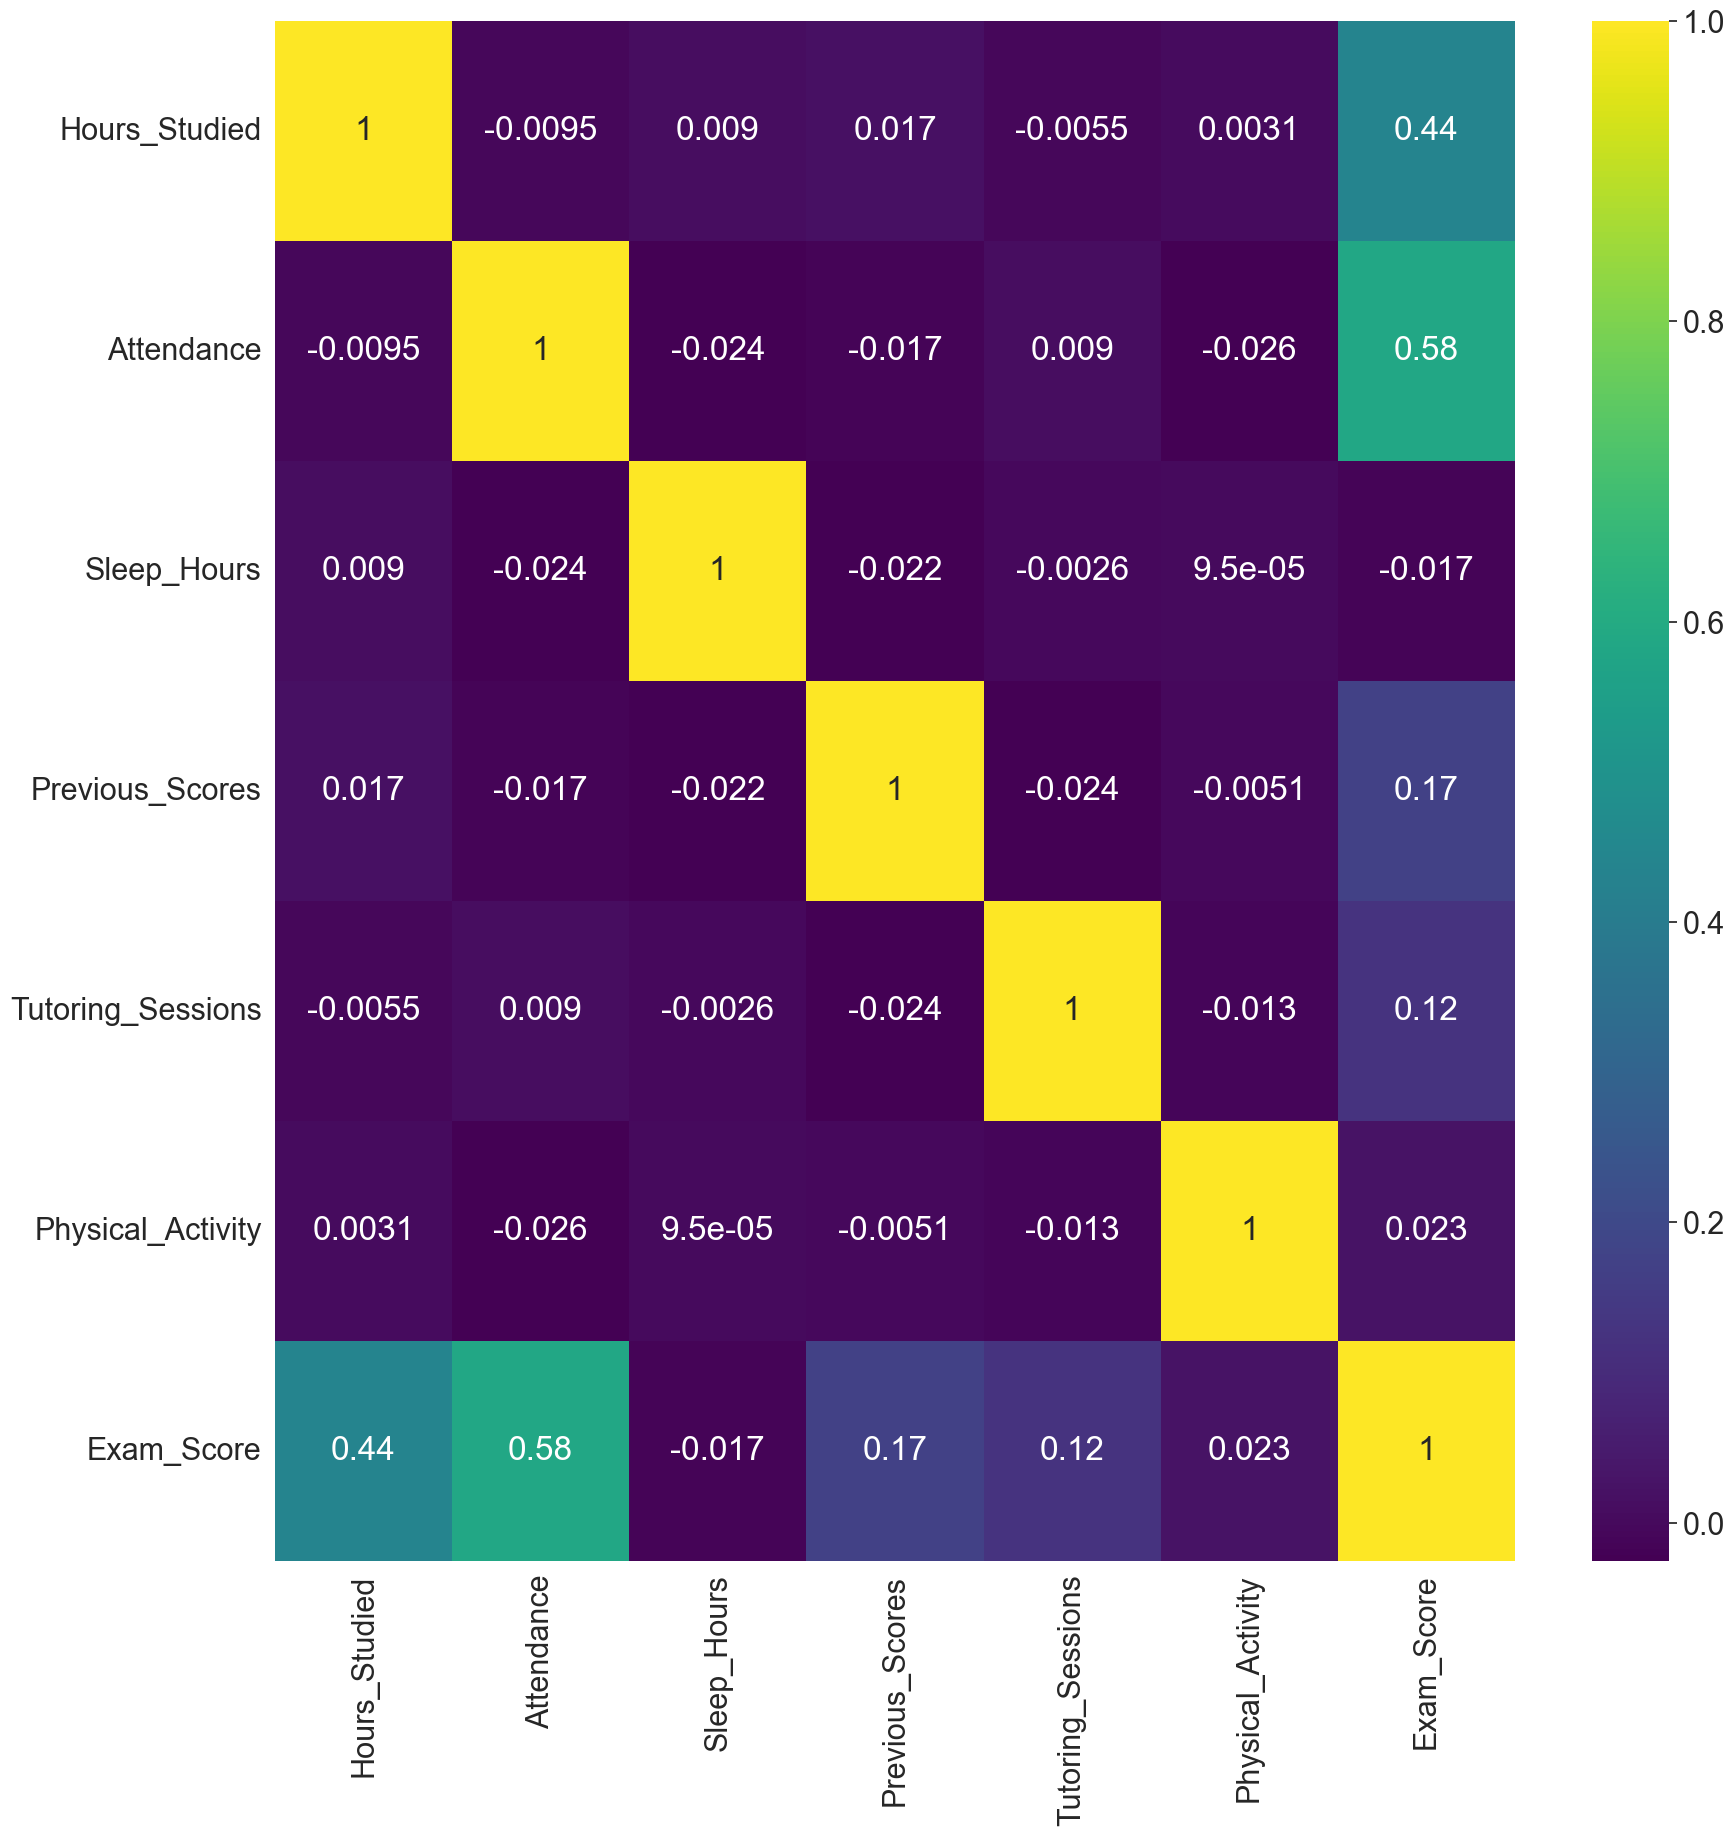

In [145]:
corr = data [['Hours_Studied',
'Attendance',
'Sleep_Hours',
'Previous_Scores',
'Tutoring_Sessions',
'Physical_Activity',
'Exam_Score']].corr()
plt.figure(figsize=(20,20))
sns.set(style="darkgrid", font_scale=2)
plt.xlabel("",fontsize=20)
plt.ylabel("",fontsize=20)

sns.heatmap(corr, cmap="viridis", annot=True)

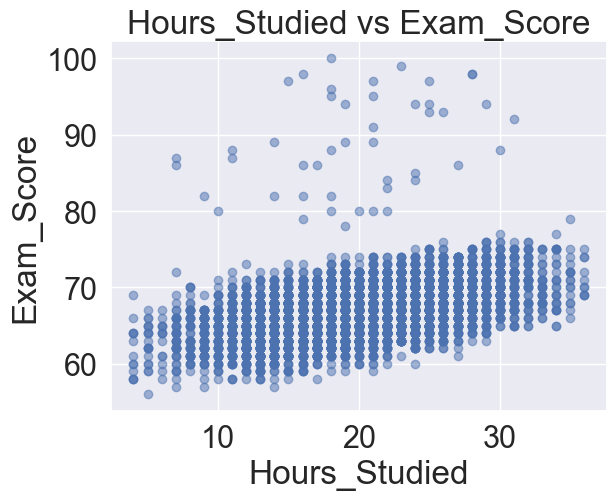

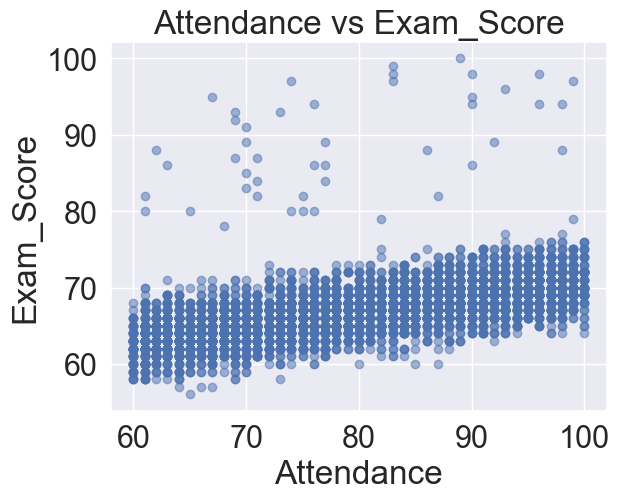

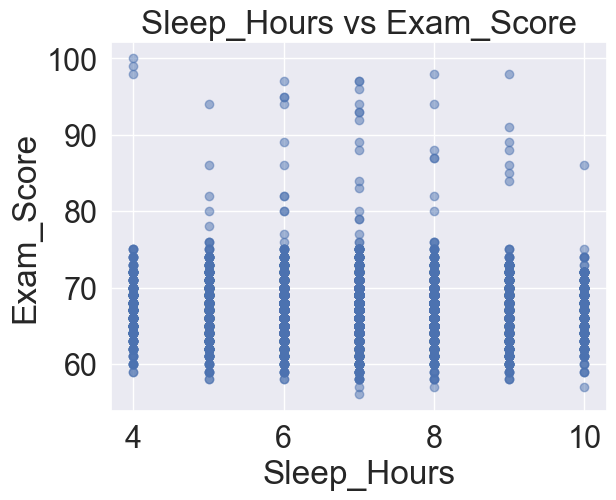

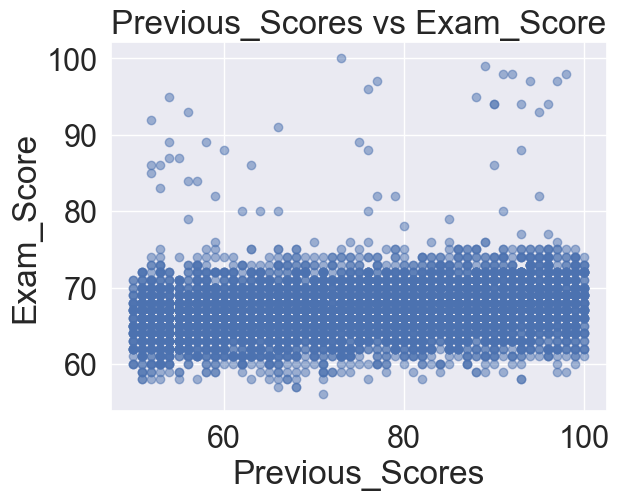

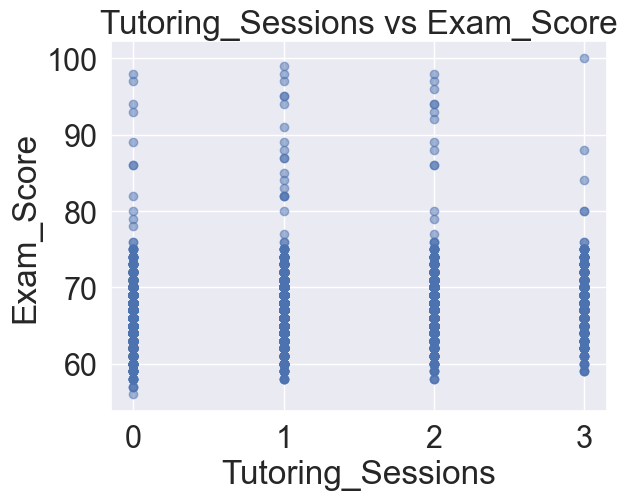

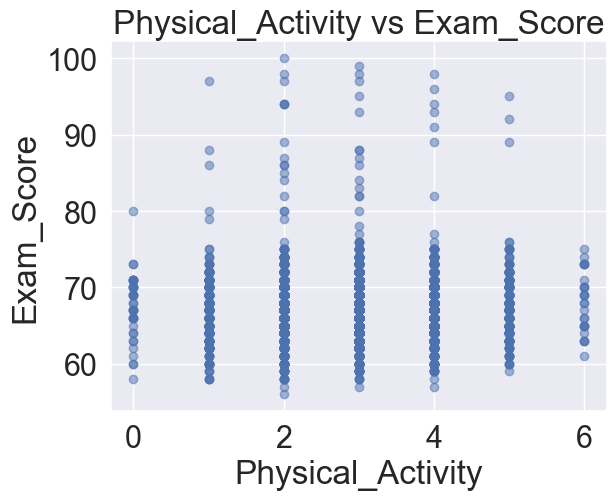

In [146]:
# Clustering (hors exam_score)
features = [col for col in data.columns if col != "Exam_Score"]
X = data[features]
kmeans = KMeans(n_clusters=3, random_state=1)
clustering_labels_km = kmeans.fit_predict(X)
data['cluster'] = kmeans.fit_predict(X)

# Visualisation : chaque colonne vs exam_score
for feature in features:
    plt.figure()
    plt.scatter(data[feature], data["Exam_Score"], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel("Exam_Score")
    plt.title(f"{feature} vs Exam_Score")
    plt.show()


On constate que des variables ont moins d'impact sur l'exam score :
- l'activité physique
- Les sessions de tutoring
- la note à l'examen précédent
- les heures de sommeil

Les variables qui ont le plus d'impact sur l'exam score sont :
- Les heures d'études
- La présence au cours

# Effet conjoint Variables qualitatives avec les heures d'études

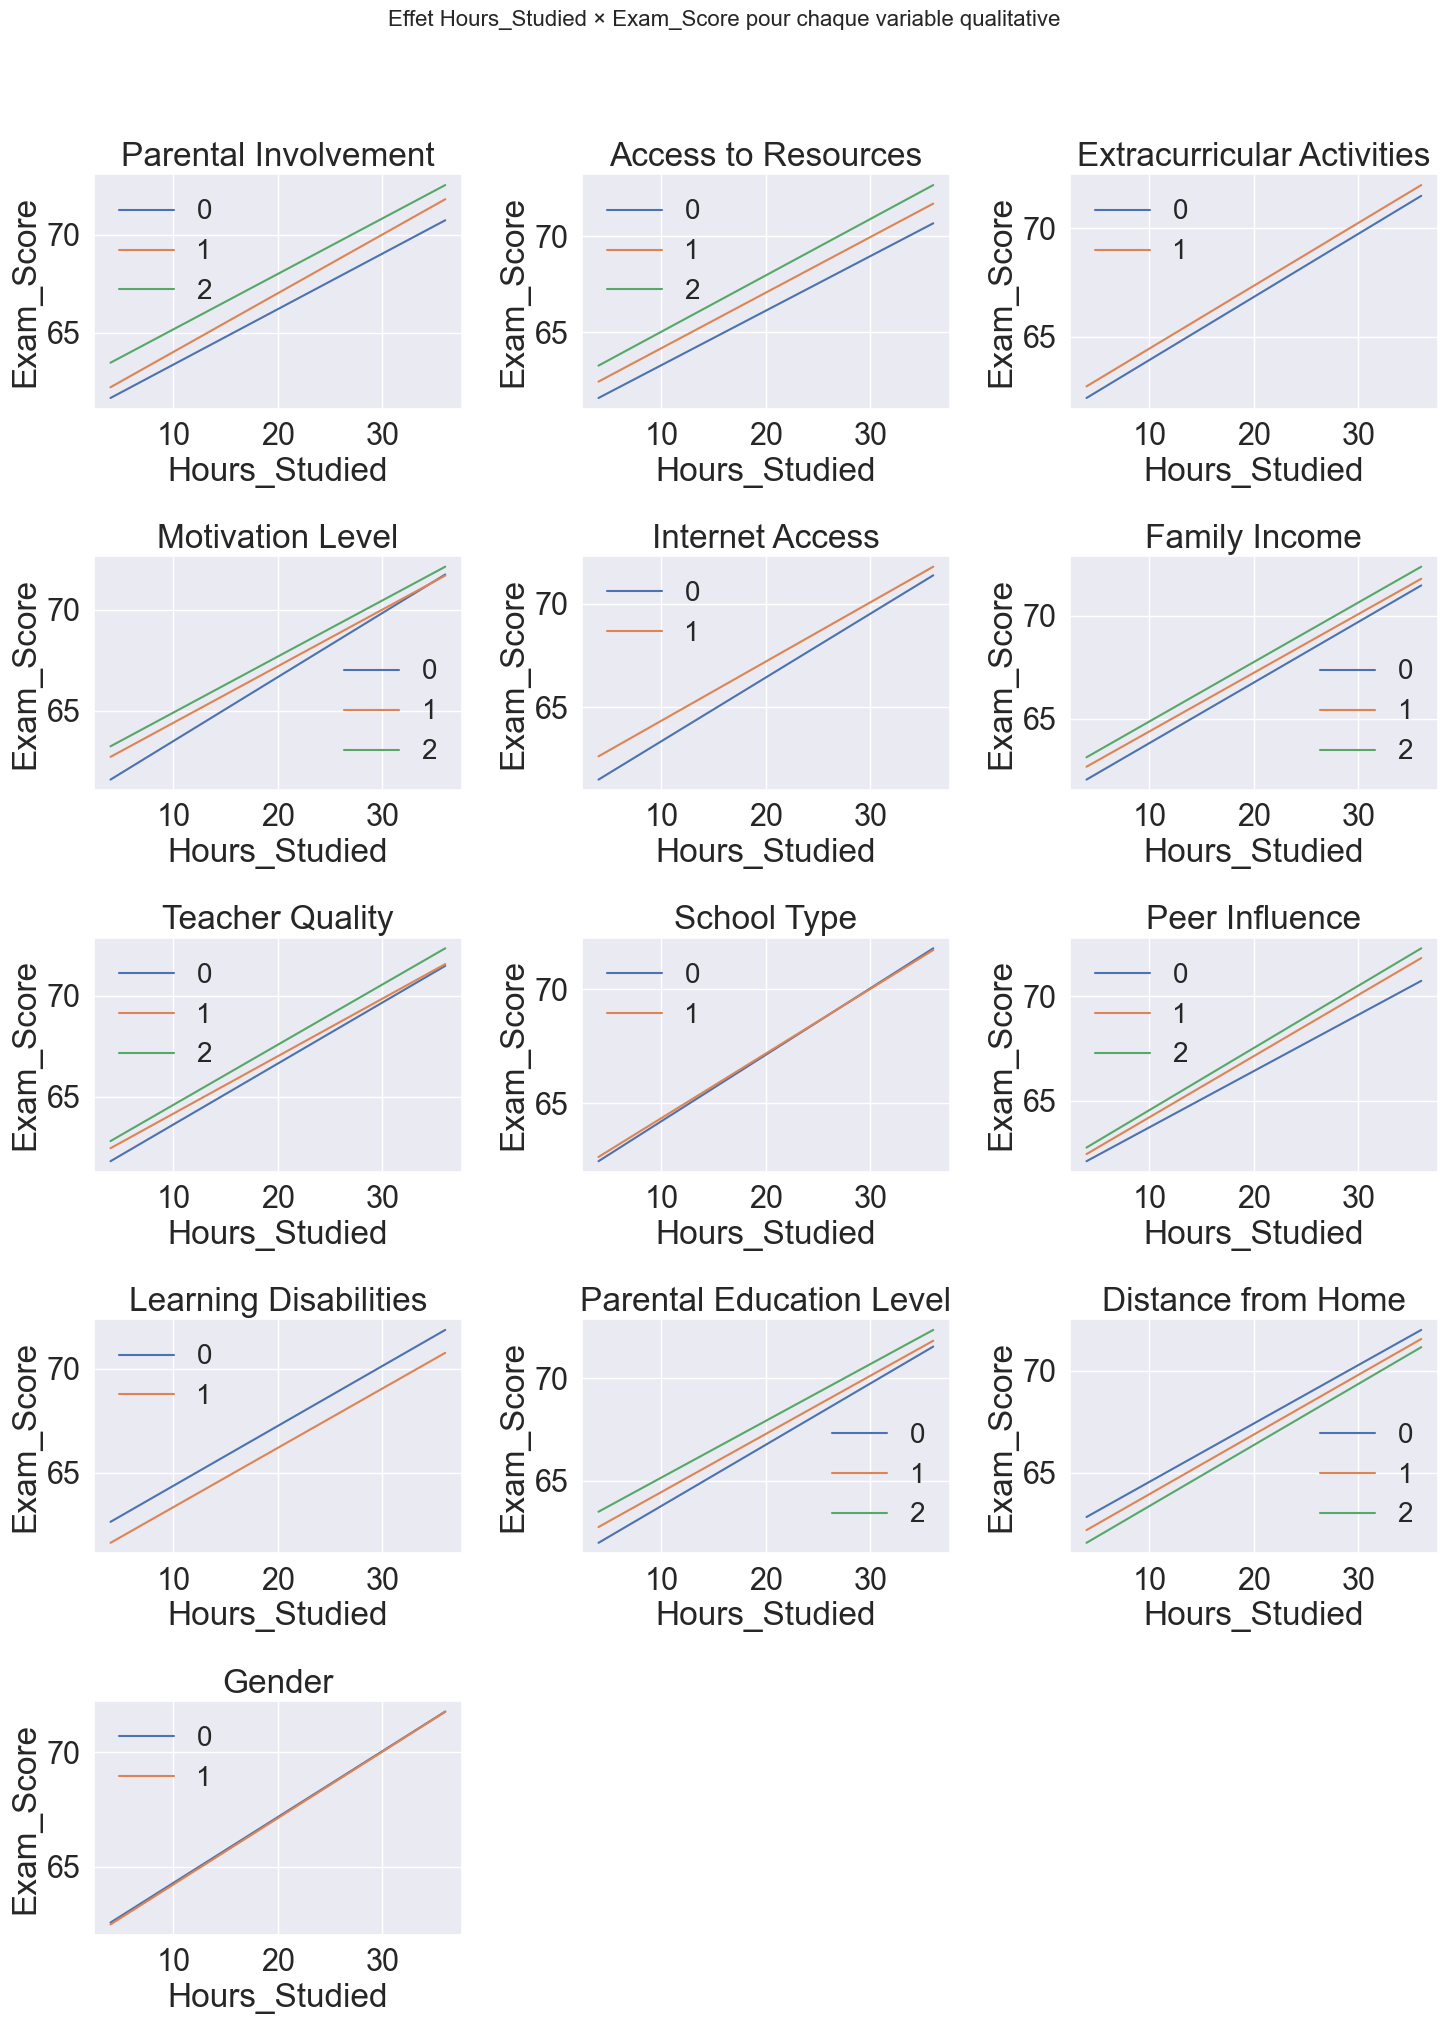

In [147]:
# 1) Sous-jeu commun à toutes les analyses
base_cols = ["Exam_Score", "Hours_Studied"]

qualitative_cols = [
    "Parental_Involvement", "Access_to_Resources", "Extracurricular_Activities",
    "Motivation_Level", "Internet_Access", "Family_Income", "Teacher_Quality",
    "School_Type", "Peer_Influence", "Learning_Disabilities",
    "Parental_Education_Level", "Distance_from_Home", "Gender"
]

def plot_hours_vs_score_by_category(df, cat_col, ax=None):
    if ax is None:
        ax = plt.gca()

    # grille commune des heures (20 points suffit pour une droite)
    hmin, hmax = df["Hours_Studied"].min(), df["Hours_Studied"].max()
    hgrid = np.linspace(hmin, hmax, 20)

    for cat in sorted(df[cat_col].dropna().unique()):
        subset = df[df[cat_col] == cat]
        if len(subset) < 2:          # pas assez de points pour une régression
            continue
        m, b = np.polyfit(subset["Hours_Studied"], subset["Exam_Score"], 1)
        ax.plot(hgrid, m * hgrid + b, label=str(cat))

    ax.set_title(cat_col.replace("_", " "))
    ax.set_xlabel("Hours_Studied")
    ax.set_ylabel("Exam_Score")
    ax.legend(fontsize="small", frameon=False)

# 3) Boucle sur les variables qualitatives ------------------------
n_vars = len(qualitative_cols)
n_cols = 3                                   # 3 graphiques par ligne
n_rows = (n_vars + n_cols - 1) // n_cols     # arrondi à l'entier supérieur

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(n_cols * 5, n_rows * 4),
                         sharex=False, sharey=False)

axes = axes.flat                              # itérable 1-dimension

for ax, cat_col in zip(axes, qualitative_cols):
    df_sub = data_quali[base_cols + [cat_col]].dropna()
    plot_hours_vs_score_by_category(df_sub, cat_col, ax=ax)

# S'il reste des axes vides (quand 13 n'est pas un multiple de 3)
for ax in axes[n_vars:]:
    ax.axis("off")

fig.suptitle("Effet Hours_Studied × Exam_Score pour chaque variable qualitative",
             fontsize=16, y=1.02)
fig.tight_layout()
plt.show()


On constate que les variables qualitatives qui ont un impact plus fort sont :
- l'investissement parental
- l'accès au ressources
- le niveau de motivation
- le niveau rémunération de la famille
- la qualité de l'enseignant
- l'influence de l'entourage
- le niveau d'éducation des parents
- la distance du domicile

# Modèle d'apprentissage

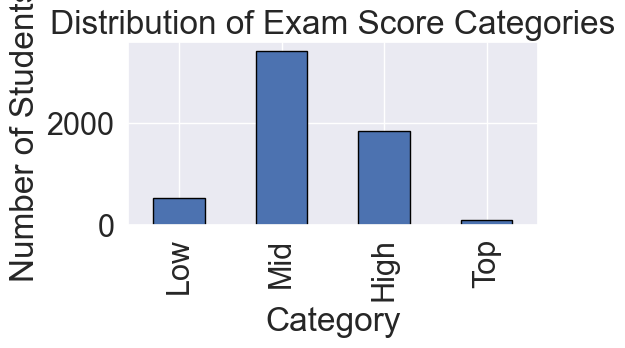

Nombre d'élèves par catégorie :
Category
Low      541
Mid     3420
High    1856
Top       98


In [148]:
# Distribution of Exam Score Categories
import pandas as pd
import matplotlib.pyplot as plt


# 2️⃣  Construire la variable catégorielle
bins   = [-float('inf'), 62.5, 68.0, 74.0, float('inf')]
labels = ['Low', 'Mid', 'High', 'Top']  # même ordre que les bornes
data['Category'] = pd.cut(
    data['Exam_Score'],
    bins=bins,
    labels=labels,
    right=True,         # 62.5 est inclus dans Mid ; 74.0 dans High
    include_lowest=True # inclut la borne inférieure dans le premier intervalle
)

# 3️⃣  Compter les effectifs
counts = data['Category'].value_counts().reindex(labels, fill_value=0)

# 4️⃣  Tracer
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', edgecolor='black')
plt.title('Distribution of Exam Score Categories')
plt.xlabel('Category')
plt.ylabel('Number of Students')
plt.tight_layout()
plt.show()
print("Nombre d'élèves par catégorie :")
print(counts.to_string())

,Accuracy,Precision,Recall,F1-score
Modèle,,,,
Random Forest,0.670,0.664,0.670,0.653
Decision Tree,0.642,0.651,0.642,0.638
KNN,0.633,0.616,0.633,0.622


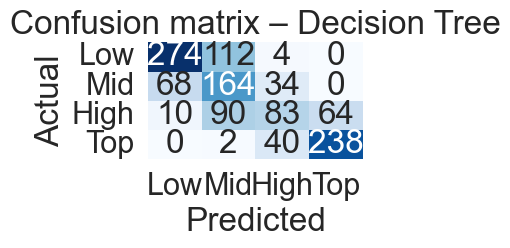

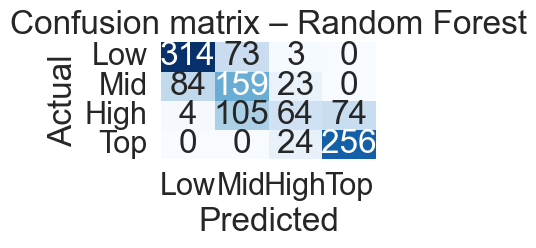

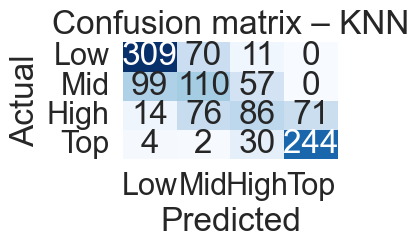

In [149]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# ------------------------------------------------------------------
TARGET_COL = "Exam_Score"

if TARGET_COL not in data.columns:
    raise ValueError(f"'{TARGET_COL}' n'est pas présent dans clean_df.")

# ------------------------------------------------------------------
# 3) Binning en quatre classes équilibrées ---------------------------
# Low = Exam Score <= 62.5
# Mid = Exam_Score 62.5 - 68
# High = Exam_Score 68.0 – 74.0
# Top = Exam_Score >= 74
data["score_bin"] = pd.qcut(data[TARGET_COL], q=4,
                          labels=["Low", "Mid", "High", "Top"])

X = data.drop(columns=[TARGET_COL, "score_bin"])
y = data["score_bin"]                # variable catégorielle (4 classes)

# ------------------------------------------------------------------
# 4) Séparation train/test stratifiée --------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------------------------------------------
# 5) Détection quali / quanti ----------------------------------------
num_cols = X.select_dtypes(include=["number"]).columns
cat_cols = X.select_dtypes(exclude=["number"]).columns

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# ------------------------------------------------------------------
# 6) Modèles ----------------------------------------------------------
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=0),
    "Random Forest": RandomForestClassifier(max_depth=10, random_state=0),
    "KNN":           KNeighborsClassifier(n_neighbors=5),
}

results, conf_mats = [], {}
labels = y.cat.categories   # ['Low', 'Mid', 'High', 'Top']

for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results.append({
        "Modèle":     name,
        "Accuracy":   accuracy_score(y_test, y_pred),
        "Precision":  precision_score(y_test, y_pred,
                                      average="weighted", zero_division=0),
        "Recall":     recall_score(y_test, y_pred,
                                   average="weighted", zero_division=0),
        "F1-score":   f1_score(y_test, y_pred,
                               average="weighted", zero_division=0),
    })
    conf_mats[name] = confusion_matrix(y_test, y_pred, labels=labels)

# ------------------------------------------------------------------
# 7) Tableau comparatif ----------------------------------------------
results_df = (
    pd.DataFrame(results)
      .set_index("Modèle")
      .sort_values("F1-score", ascending=False)
      .round(3)
)
display(results_df)

# ------------------------------------------------------------------
# 8) Heatmaps des matrices de confusion ------------------------------
for name, cm in conf_mats.items():
    plt.figure(figsize=(4, 3))
    heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha="right")
    plt.title(f"Confusion matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


,Accuracy,Precision,Recall,F1-score
Modèle,,,,
Random Forest,0.634,0.607,0.634,0.615
Decision Tree,0.579,0.572,0.579,0.575
KNN,0.573,0.576,0.573,0.571


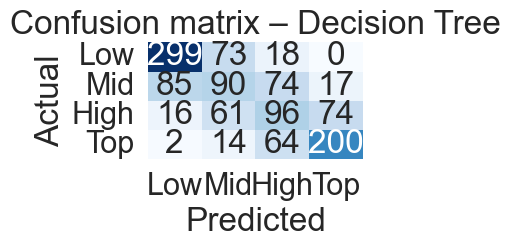

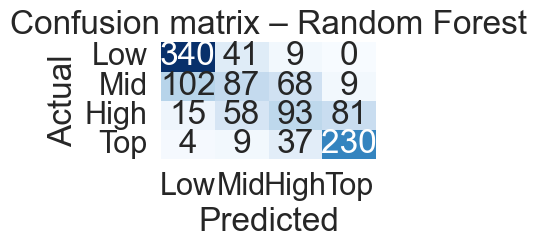

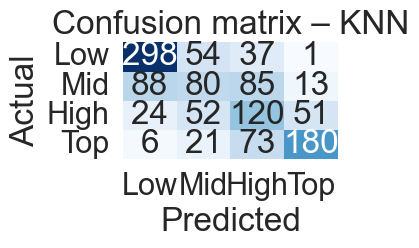

In [150]:
# ----------------------------------------------------------------
# 0) LISTES des variables retenues -------------------------------
qualitative_cols = [
    "Parental_Involvement", "Access_to_Resources", "Motivation_Level",
    "Family_Income", "Teacher_Quality", "Peer_Influence",
    "Parental_Education_Level", "Distance_from_Home"
]

quantitative_cols = ["Hours_Studied", "Attendance"]

TARGET_COL = "Exam_Score"                             # colonne-score numérique

# ----------------------------------------------------------------
# 1) Sous-ensemble & nettoyage -----------------------------------
features = qualitative_cols + quantitative_cols
df = data_quali[features + [TARGET_COL]].dropna()

# ----------------------------------------------------------------
# 2) Binning en quartiles (Low / Mid / High / Top) ---------------
df["score_bin"] = pd.qcut(df[TARGET_COL], q=4,
                          labels=["Low", "Mid", "High", "Top"])

X = df[features]
y = df["score_bin"]            # variable catégorielle équilibrée (dtype category)

# ----------------------------------------------------------------
# 3) Split train / test (stratifié) -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ----------------------------------------------------------------
# 4) Pré-traitement : scaler num + one-hot cat --------------------
preprocess = ColumnTransformer([
    ("num", StandardScaler(), quantitative_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), qualitative_cols)
])

# ----------------------------------------------------------------
# 5) Définition des modèles --------------------------------------
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=0),
    "Random Forest": RandomForestClassifier(max_depth=10, random_state=0),
    "KNN":           KNeighborsClassifier(n_neighbors=5)
}

results, conf_mats = [], {}
labels = y.cat.categories      # ['Low', 'Mid', 'High', 'Top']

# ----------------------------------------------------------------
# 6) Entraînement / évaluation -----------------------------------
for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results.append({
        "Modèle":     name,
        "Accuracy":   accuracy_score(y_test, y_pred),
        "Precision":  precision_score(y_test, y_pred, average="weighted", zero_division=0),
        "Recall":     recall_score(y_test, y_pred, average="weighted", zero_division=0),
        "F1-score":   f1_score(y_test, y_pred, average="weighted", zero_division=0)
    })
    conf_mats[name] = confusion_matrix(y_test, y_pred, labels=labels)

# ----------------------------------------------------------------
# 7) Tableau récapitulatif ---------------------------------------
results_df = (pd.DataFrame(results)
              .set_index("Modèle")
              .sort_values("F1-score", ascending=False)
              .round(3))
display(results_df)

# ----------------------------------------------------------------
# 8) Heatmaps des matrices de confusion --------------------------
for name, cm in conf_mats.items():
    plt.figure(figsize=(4, 3))
    heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha="right")
    plt.title(f"Confusion matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual", rotation=90)
    plt.tight_layout()
    plt.show()

,Accuracy,Precision,Recall,F1-score
Modèle,,,,
Random Forest,0.686,0.666,0.686,0.671
Decision Tree,0.599,0.598,0.599,0.597
KNN,0.516,0.534,0.516,0.519


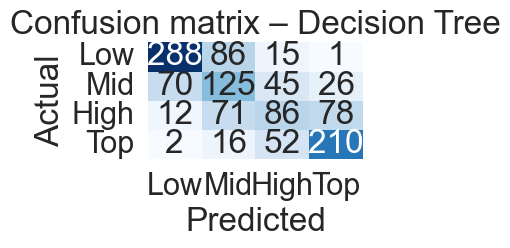

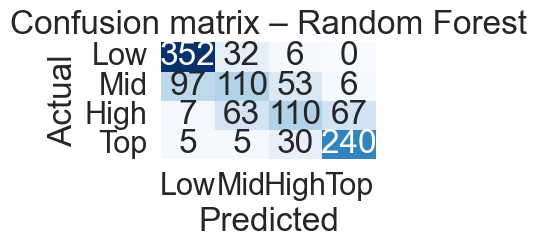

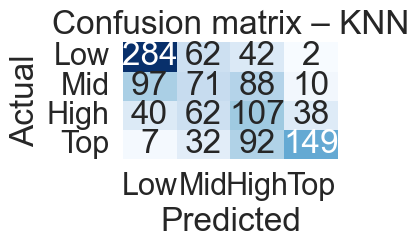

In [151]:
data_quali = pd.read_parquet("../data/clean_df_with_categoricals/")
# ------------------------------------------------------------------
TARGET_COL = "Exam_Score"

if TARGET_COL not in data_quali.columns:
    raise ValueError(f"'{TARGET_COL}' n'est pas présent dans clean_df.")

# ------------------------------------------------------------------
# 3) Binning en quatre classes équilibrées ---------------------------
# Low = Exam Score <= 62.5
# Mid = Exam_Score 62.5 - 68
# High = Exam_Score 68.0 – 74.0
# Top = Exam_Score >= 74
data_quali["score_bin"] = pd.qcut(data_quali[TARGET_COL], q=4,
                          labels=["Low", "Mid", "High", "Top"])

X = data_quali.drop(columns=[TARGET_COL, "score_bin"])
y = data_quali["score_bin"]                # variable catégorielle (4 classes)

# ------------------------------------------------------------------
# 4) Séparation train/test stratifiée --------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------------------------------------------
# 5) Détection quali / quanti ----------------------------------------
num_cols = X.select_dtypes(include=["number"]).columns
cat_cols = X.select_dtypes(exclude=["number"]).columns

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# ------------------------------------------------------------------
# 6) Modèles ----------------------------------------------------------
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=6, random_state=0),
    "Random Forest": RandomForestClassifier(max_depth=10, random_state=0),
    "KNN":           KNeighborsClassifier(n_neighbors=5),
}

results, conf_mats = [], {}
labels = y.cat.categories   # ['Low', 'Mid', 'High', 'Top']

for name, clf in models.items():
    pipe = Pipeline([("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results.append({
        "Modèle":     name,
        "Accuracy":   accuracy_score(y_test, y_pred),
        "Precision":  precision_score(y_test, y_pred,
                                      average="weighted", zero_division=0),
        "Recall":     recall_score(y_test, y_pred,
                                   average="weighted", zero_division=0),
        "F1-score":   f1_score(y_test, y_pred,
                               average="weighted", zero_division=0),
    })
    conf_mats[name] = confusion_matrix(y_test, y_pred, labels=labels)

# ------------------------------------------------------------------
# 7) Tableau comparatif ----------------------------------------------
results_df = (
    pd.DataFrame(results)
      .set_index("Modèle")
      .sort_values("F1-score", ascending=False)
      .round(3)
)
display(results_df)

# ------------------------------------------------------------------
# 8) Heatmaps des matrices de confusion ------------------------------
for name, cm in conf_mats.items():
    plt.figure(figsize=(4, 3))
    heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha="right")
    plt.title(f"Confusion matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
